In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Detección de anomalías con Isolation Forest

## 1. Preparación de datos

In [4]:
# Leer el archivo de csv y asignarlo al objeto 'df'df=pd.merge(df,df_Pobl, on='descrip_poblac_suministro', how='inner')
df = pd.read_csv('C://Prueba//Vanti//data_challenge.csv')
# Convertir la fecha a datetime si no lo está ya
df['fec_contab_documento'] = pd.to_datetime(df['fec_contab_documento'])
# Leer el archivo con información poblacional por ciudad es un .csv y asignarlo al objeto 'df'
df_Pobl = pd.read_excel('C://Prueba//Vanti//Pobla_2024Est.xlsx')
df=pd.merge(df,df_Pobl, on='descrip_poblac_suministro', how='inner')
df = df.drop(['Codi', 'Dep'], axis=1)
df['descrip_poblac_suministro'] = df['descrip_poblac_suministro'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108895 entries, 0 to 108894
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   cuenta                     108895 non-null  object        
 1   fec_contab_documento       108895 non-null  datetime64[ns]
 2   consumo                    108895 non-null  float64       
 3   categoria_cliente          108895 non-null  int64         
 4   porcion                    100973 non-null  object        
 5   dias_fact                  108895 non-null  int64         
 6   descrip_poblac_suministro  108895 non-null  category      
 7   Pobl_2024                  108698 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 5.9+ MB


### Preparación de datos

In [5]:
# Seleccionamos las variables relevantes
features = ['cuenta', 'fec_contab_documento', 'consumo', 'categoria_cliente', 'dias_fact']
df_clean = df[features].dropna()

# Convertimos la fecha a datetime
df_clean['fec_contab_documento'] = pd.to_datetime(df_clean['fec_contab_documento'])

# Creamos una variable para el consumo diario
df_clean['consumo_diario'] = df_clean['consumo'] / df_clean['dias_fact']

## 2. Detección de anomalías con Isolation Forest

### Preparamos los datos para el modelo

In [6]:
# Preparamos los datos para el modelo
X = df_clean[['consumo', 'consumo_diario']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Aplicamos Isolation Forest

In [7]:
# Aplicamos Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_clean['anomalia'] = iso_forest.fit_predict(X_scaled)

## 3. Análisis de resultados

In [9]:
# Análisis de resultados
anomalias = df_clean[df_clean['anomalia'] == -1]
print(f"Número total de anomalías detectadas: {len(anomalias)}")

# Calculamos estadísticas para anomalías y no anomalías
stats_anomalias = anomalias['consumo'].describe()
stats_normales = df_clean[df_clean['anomalia'] == 1]['consumo'].describe()

print("\nEstadísticas de consumo para anomalías:")
print(stats_anomalias)
print("\nEstadísticas de consumo para registros normales:")
print(stats_normales)

Número total de anomalías detectadas: 1087

Estadísticas de consumo para anomalías:
count     1087.000000
mean      1011.839460
std       4859.482504
min        136.000000
25%        180.449954
50%        270.000000
75%        479.500000
max      60061.000000
Name: consumo, dtype: float64

Estadísticas de consumo para registros normales:
count    107808.000000
mean         13.890974
std          13.598610
min           0.000000
25%           5.000000
50%          11.000000
75%          19.000000
max         140.000000
Name: consumo, dtype: float64


## 4. Visualización

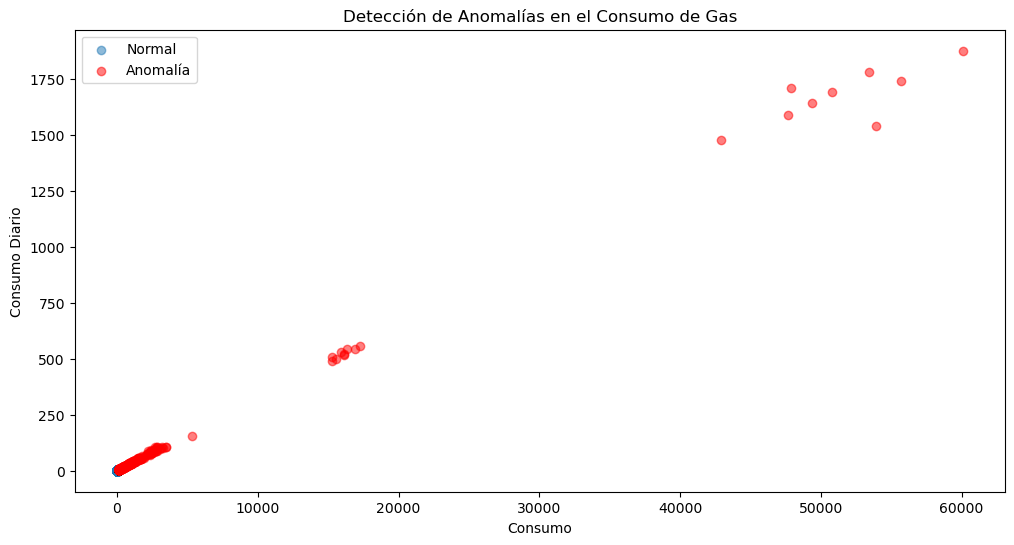

In [11]:
# Visualización
plt.figure(figsize=(12, 6))
plt.scatter(df_clean[df_clean['anomalia'] == 1]['consumo'], 
            df_clean[df_clean['anomalia'] == 1]['consumo_diario'], 
            label='Normal', alpha=0.5)
plt.scatter(anomalias['consumo'], anomalias['consumo_diario'], 
            color='red', label='Anomalía', alpha=0.5)
plt.xlabel('Consumo')
plt.ylabel('Consumo Diario')
plt.title('Detección de Anomalías en el Consumo de Gas')
plt.legend()
plt.show()

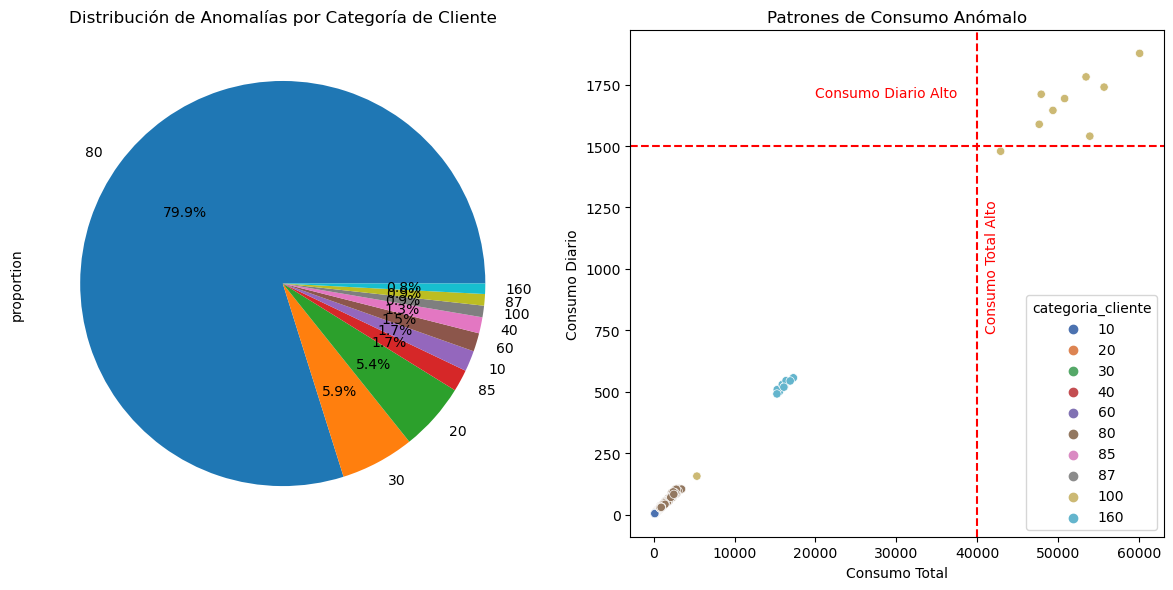

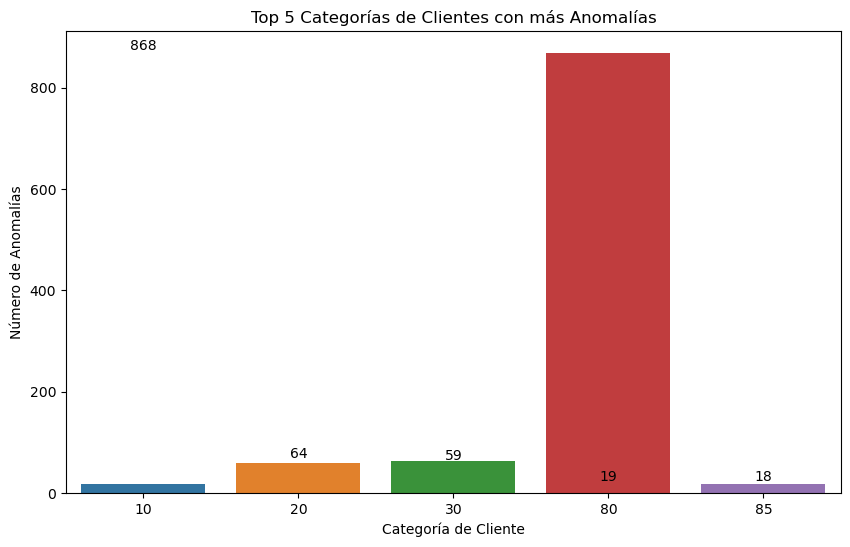

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Gráfico categorías de clientes con anomalías(outlier)
plt.figure(figsize=(12, 6))
plt.subplot(121)
anomalias['categoria_cliente'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribución de Anomalías por Categoría de Cliente')

# Gráfico de dispersión para patrones de consumo
plt.subplot(122)
sns.scatterplot(data=anomalias, x='consumo', y='consumo_diario', hue='categoria_cliente', palette='deep')
plt.title('Patrones de Consumo Anómalo')
plt.xlabel('Consumo Total')
plt.ylabel('Consumo Diario')

# Añadir líneas para resaltar los grupos principales de outlier
plt.axhline(y=1500, color='r', linestyle='--')
plt.axvline(x=40000, color='r', linestyle='--')

# Añadir texto explicativo
plt.text(20000, 1700, 'Consumo Diario Alto', color='red')
plt.text(41000, 750, 'Consumo Total Alto', color='red', rotation=90)

plt.tight_layout()
plt.show()

# Gráfico de barras top 5 categorías con más outlier
top_5_categories = anomalias['categoria_cliente'].value_counts().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_categories.index, y=top_5_categories.values)
plt.title('Top 5 Categorías de Clientes con más Anomalías')
plt.xlabel('Categoría de Cliente')
plt.ylabel('Número de Anomalías')
for i, v in enumerate(top_5_categories.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

## 5. Análisis temporal de anomalías

In [14]:
# Análisis temporal de anomalías
anomalias_por_mes = anomalias.groupby(anomalias['fec_contab_documento'].dt.to_period('M')).size()
print("\nDistribución de anomalías por mes:")
print(anomalias_por_mes)


Distribución de anomalías por mes:
fec_contab_documento
2023-03     1
2023-04    73
2023-05    75
2023-06    80
2023-07    79
2023-08    81
2023-09    82
2023-10    86
2023-11    78
2023-12    83
2024-01    67
2024-02    81
2024-03    73
2024-04    74
2024-05    74
Freq: M, dtype: int64


## 6. Análisis por categoría de cliente

In [13]:
# Análisis por categoría de cliente
anomalias_por_categoria = anomalias['categoria_cliente'].value_counts(normalize=True)
print("\nDistribución de anomalías por categoría de cliente:")
print(anomalias_por_categoria)


Distribución de anomalías por categoría de cliente:
categoria_cliente
80     0.798528
30     0.058878
20     0.054278
85     0.017479
10     0.016559
60     0.014719
40     0.012879
100    0.009200
87     0.009200
160    0.008280
Name: proportion, dtype: float64


# Análisis detallado y recomendaciones:

## Análisis de Anomalías:
**a) Distribución Temporal:** 
- Las anomalías se distribuyen de manera relativamente uniforme a lo largo de los meses, con un ligero aumento en los meses de verano (agosto a octubre).
- Hay una disminución notable en enero de 2024, que podría indicar una mejora en la detección o una reducción real de anomalías.

**b) Categorías de Clientes:**
- La categoría 80 representa casi el 80% de las anomalías detectadas.
- Las categorías 30 y 20 siguen con aproximadamente 5% cada una.
- Las demás categorías tienen una representación menor en las anomalías.

**c) Patrón de Consumo:** El gráfico muestra dos grupos principales de anomalías:
- Un grupo con consumo diario muy alto (>1500 unidades)
- Un grupo con consumo total muy alto (>40000 unidades)

## Recomendaciones y Estrategias:
**a) Para la Categoría 80 (Principal fuente de anomalías):**
- Implementar un programa de auditoría específico para este segmento.
- Desarrollar un sistema de alerta temprana para detectar cambios súbitos en el consumo.
- Ofrecer incentivos para la actualización de equipos a modelos más eficientes.
- Proporcionar educación personalizada sobre el uso eficiente del gas.

**b) Para las Categorías 30 y 20:**
- Realizar inspecciones focalizadas para identificar posibles fugas o mal funcionamiento de equipos.
- Ofrecer planes de mantenimiento preventivo.
- Implementar programas de concienciación sobre el uso responsable del gas.

**c) Estrategias Estacionales:**
- Reforzar las inspecciones y el mantenimiento preventivo antes de los meses de verano.
- Desarrollar campañas de concienciación sobre el uso eficiente del gas en temporadas de alto consumo.

**d) Para Anomalías de Alto Consumo Diario:**
- Investigar inmediatamente estos casos para descartar fugas importantes o fraude.
- Implementar un sistema de monitoreo en tiempo real para estos clientes.
- Ofrecer auditorías energéticas gratuitas para identificar oportunidades de eficiencia.

**e) Para Anomalías de Alto Consumo Total:**
- Revisar los ciclos de facturación para asegurar que no sean errores administrativos.
- Analizar el historial de consumo para identificar patrones inusuales.
- Ofrecer planes de tarifa escalonada que incentiven la reducción del consumo.

**f) Estrategias Generales:**
- Mejorar la comunicación con los clientes, informándoles proactivamente sobre patrones inusuales en su consumo.
- Desarrollar una aplicación móvil que permita a los clientes monitorear su consumo en tiempo real.
- Implementar un programa de recompensas para clientes que mantengan un consumo estable y eficiente.
- Utilizar análisis predictivo para anticipar posibles anomalías basadas en patrones históricos.

**g) Mejora Continua:**

- Realizar revisiones periódicas del modelo de detección de anomalías para mejorar su precisión.
- Establecer un equipo dedicado a investigar y resolver las anomalías detectadas.
- Crear un sistema de retroalimentación donde los resultados de las investigaciones se utilicen para mejorar el modelo.


## Impacto en Satisfacción y Rentabilidad:
- La detección temprana de anomalías puede prevenir facturas inesperadamente altas, mejorando la satisfacción del cliente.
- La reducción de fugas y consumos anómalos disminuirá las pérdidas, aumentando la rentabilidad.
- Los programas de eficiencia y mantenimiento preventivo pueden generar lealtad del cliente a largo plazo.
- La comunicación proactiva y las herramientas de monitoreo empoderarán a los clientes, mejorando su percepción del servicio.

**_Implementando estas estrategias, la empresa puede mejorar significativamente la eficiencia operativa, la satisfacción del cliente y la rentabilidad, al tiempo que promueve un uso más responsable y sostenible del gas natural._**